In [142]:
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import matplotlib.gridspec as gridspec
img_max_xy = 96

class DataLoader(data.Dataset):
    def __init__(self, data_path, txt_list, classes=1000, rot = 0):
        self.data_path = data_path
        self.rot = rot
        self.names, _ = self.__dataset_info(txt_list)
        self.N = len(self.names)
        self.permutations = self.__retrive_permutations(classes)

        self.__image_transformer = transforms.Compose([
            transforms.Resize(img_max_xy, Image.BILINEAR),
            transforms.CenterCrop(img_max_xy - 1)])
        self.__augment_tile = transforms.Compose([
            transforms.RandomCrop(25),
            transforms.Resize((30, 30), Image.BILINEAR),
            #transforms.Lambda(rgb_jittering),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            # std =[0.229, 0.224, 0.225])
        ])
        
        self.indices = set([0])
        self.num_angles = 4
        self.num_rotations_per_img = 1
        # the last angle is 360 and 1st angle is 0, both give the original image.
        # 360 is not useful so remove it
        self.angles = torch.linspace(0, 360, 4 + 1)[:-1]

    def __getitem__(self, index):
        framename = self.data_path + '/' + self.names[index]
       
        order = np.random.randint(len(self.permutations))
        
        img = Image.open(framename).convert('RGB')
        #if np.random.rand() < 0.30:
        #    img = img.convert('LA').convert('RGB')

        if img.size[0] != img_max_xy:
            img = self.__image_transformer(img)

        s = float(img.size[0]) / 3
        a = s / 2
        tiles = [None] * 9  
        orig_tiles = [None] * 9  
        
        data, labels = [], []
        indices = self.indices if self.indices else set(range(len(sample["data"])))
        orig_img = img
        
        if(self.rot == 1):
            #print(self.permutations[order])
            #print("ROTATO POTATO")
            #print("Rotation num = ", self.permutations[order][9])
            #print("ANGLE = ", self.angles[int(self.permutations[order][9])])
            img = TF.rotate(img, self.angles[int(self.permutations[order][9])])
        
            
        for n in range(9):
            i = n / 3
            j = n % 3
            c = [a * i * 2 + a, a * j * 2 + a]
            c = np.array([c[1] - a, c[0] - a, c[1] + a + 1, c[0] + a + 1]).astype(int)
           
            tile = img.crop(c.tolist())
            orig_tile = orig_img.crop(c.tolist())
            
            tile = self.__augment_tile(tile)
            orig_tile = self.__augment_tile(orig_tile)
                
            # Normalize the patches indipendently to avoid low level features shortcut
            m, s = tile.view(3, -1).mean(dim=1).numpy(), tile.view(3, -1).std(dim=1).numpy()
            s[s == 0] = 1
            #norm = transforms.Normalize(mean=m.tolist(), std=s.tolist())
            tile = tile #norm(tile)
            tiles[n] = tile
            orig_tiles[n] = orig_tile #norm(orig_tile)
        
        #print(tiles)

        # NEED TO SAMPLE THIS BEFORE ROTATION TO DETERMINE THE ROTATION
        # MAYBE KEEP THE PERMUTATIONS IN TWO 
        # ie: self.per[order]["ROT"] has the angle
        # self.per[order]["PUZ"] has the puzzle pieces
        # Which means using the same code is possible 
        
        data = [tiles[int(self.permutations[order][t])] for t in range(9)]
        data = torch.stack(data, 0)
       

        return data, int(order), orig_tiles

    def __len__(self):
        return len(self.names)

    def __dataset_info(self, txt_labels):
        with open(txt_labels, 'r') as f:
            images_list = f.readlines()

        file_names = []
        labels = []
        
        for row in images_list:
            row = row.split('\n')
            file_names.append(row[0])
            labels.append(0)

        return file_names, labels
    
    def __retrive_permutations(self, classes):
        if(self.rot == 1):
            all_perm = np.load('permutations/permutations_rot_hamming_max_%d.npy' %(classes))
        else:
            all_perm = np.load('permutations/permutations_hamming_max_%d.npy' % (classes))
            
        # from range [1,9] to [0,8]
        if all_perm.min() == 1:
            all_perm = all_perm - 1

        return all_perm

In [143]:
def rgb_jittering(im):
    im = np.array(im, 'int32')
    for ch in range(3):
        im[:, :, ch] += np.random.randint(-2, 2)
    im[im > img_max_xy-1] = img_max_xy-1
    im[im < 0] = 0
    return im.astype('uint8')

In [169]:
ad = "../data/"

trainpath = ad +'/train'
train_data = DataLoader(trainpath, ad +'/list_train.txt',
                            classes=40, rot = 0)

In [170]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers=1)

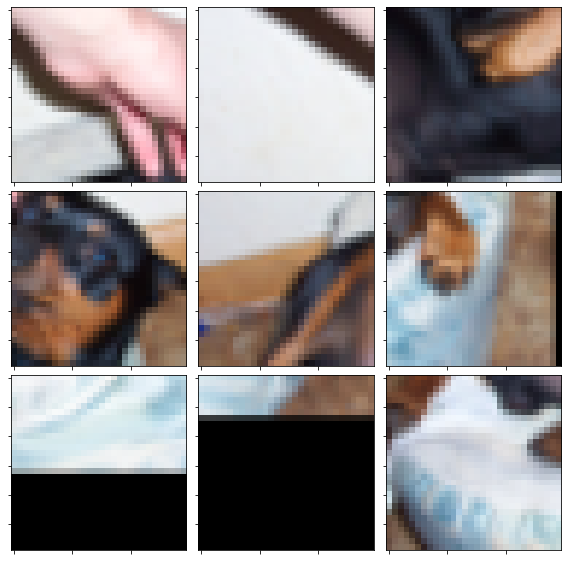

In [171]:
for i, (images, labels, original) in enumerate(train_loader):
        if (i == 300):
            break
            
plt.figure(figsize = (10,10))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(1,10):
   # i = i + 1 # grid spec indexes from 0
    img = images[0][i - 1][:]
    img = np.transpose(np.array(img), (1,2,0))
    ax1 = plt.subplot(gs1[i - 1])
    plt.imshow(img)
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

plt.show()

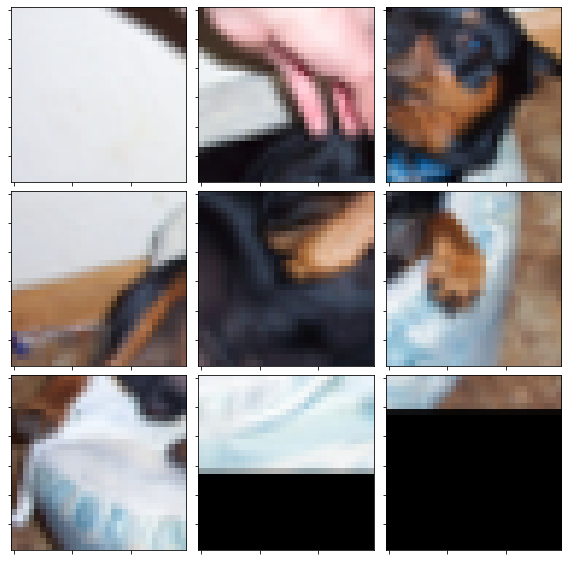

In [168]:
plt.figure(figsize = (10,10))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(1,10):
   # i = i + 1 # grid spec indexes from 0
    img = original[i-1][0][:]
    img = np.transpose(np.array(img), (1,2,0))
    ax1 = plt.subplot(gs1[i - 1])
    plt.imshow(img)
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

plt.show()